In [1]:
#!/usr/bin/env python3
import os
from os import path
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
outpath = "/home/dave/HRM/data/28-Feb-2019"
inpath = '/home/dave/HRM/data/28-Feb-2019/Wimeans_20190228T171607.txt'

### Import extracted fluorescent intensities [2], then plot each curve [3] 

In [2]:
time_series = pd.read_csv(inpath)
X, Y = time_series.shape
num_points = np.linspace(1, X+1, X+1, dtype = int)
columns = np.linspace(1, Y, Y, dtype = int)
time_series = pd.read_csv(inpath, names = columns)
[X, Y, num_points.shape, time_series.shape]

[569, 4950, (570,), (570, 4950)]

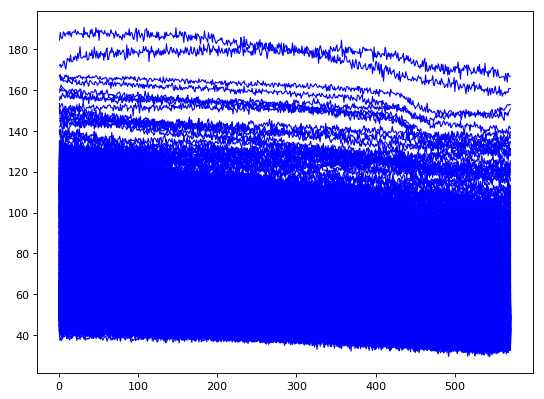

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
# Create a new subplot from a grid of 1x1
plt.subplot(1, 1, 1)

for i in range(1,Y+1):
    plt.plot(num_points, time_series[i], color="blue", linewidth=1.0, linestyle="-")

plt.show()

### Use Savgol Filter [4] then take derivative [5] and plot [6]

/home/dave/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


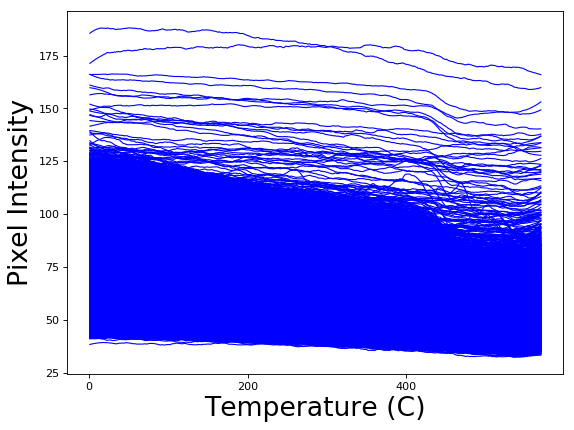

In [4]:
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Temperature (C)', fontsize=24)
plt.ylabel('Pixel Intensity', fontsize=24)
plt.rcParams.update({'font.size': 22})
# Create a new subplot from a grid of 1x1
plt.subplot(1, 1, 1)

for i in range(1,Y+1):
    plt.plot(range(1,X+2), savgol_filter(time_series[i], 31, 2), color="blue", linewidth=1.0, linestyle="-")

plt.show()

In [5]:
diff_data = []

for i in range(1,Y+1):
    diff_data.append(-savgol_filter(np.diff(savgol_filter(time_series[i], 95, 3)), 95, 3))


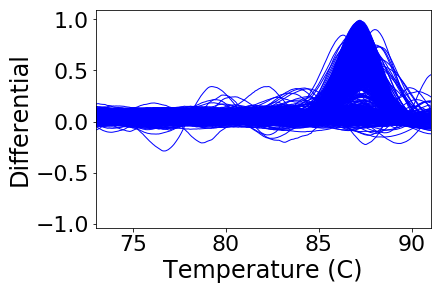

In [6]:
#columns = np.linspace(1, X-1, X-1, dtype = int)
diff_frame = pd.DataFrame(diff_data)
diff_frame_trans = diff_frame.T
# Create a new subplot from a grid of 1x1
fig, ax = plt.subplots()
ax.set_xlim([73,91])
plt.xlabel('Temperature (C)', fontsize=24)
plt.ylabel('Differential', fontsize=24)
plt.rcParams.update({'font.size': 16})

for i in range(1,Y):
    plt.plot(np.linspace(68.0, 92.9, X), diff_frame_trans[i], color="blue", linewidth=1.0, linestyle="-")

plt.show()
fig.savefig(path.join(outpath,"Derivative_All_Plots.jpg"))

### Determine peaks on criteria 

1) within 20 images of average mean of peak

2) peak of derivative is greater than 0.5

Peaks within this critea are assigned values while non-peaks are assigned NaN

Timeseries converted to temperature


In [7]:
peaks = np.zeros((Y+1,1))
for i in range(0,Y):
    peaks[i, 0] = diff_frame_trans[i].idxmax()
peaks_median = np.median(peaks)
half_width = 10

peaks = np.zeros((Y,1))
for i in range(0,Y):
    if (diff_frame_trans[i].idxmax() > (peaks_median-half_width) and 
        diff_frame_trans[i].idxmax() < (peaks_median+half_width) and 
        diff_frame_trans[i].max() > 0.5):
        peaks[i, 0] = diff_frame_trans[i].idxmax()*(92.9-75.0)/X+75.0
    else:
        peaks[i, 0] = float('NaN')
peaks_median

437.0

### Histogram of Peaks

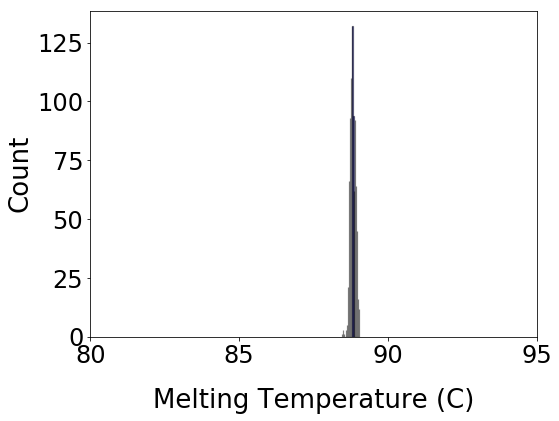

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Melting Temperature (C)', fontsize = 26)
ax.xaxis.labelpad = 20
plt.ylabel('Count', fontsize = 26)
plt.rcParams['font.size'] = 26
plt.xlim(80, 95)
num_bins = 101
n, bins, patches = plt.hist(peaks, num_bins, facecolor='blue', alpha=0.5,
                           edgecolor='black', linewidth=1.2)
plt.show()
fig.savefig(path.join(outpath,"Peak_Histogram.jpg"))

### Initial histogram of intensities

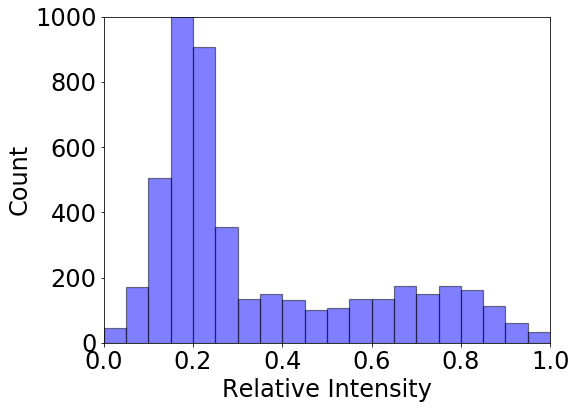

0.2296969696969697

In [9]:
time_series_normalized = np.zeros((1,Y))

for i in range(1,Y+1):
    if (time_series.T[1][i]/time_series.T[1].max() > 0.05) and (time_series.T[1][i]/time_series.T[1].max() < 0.70):
        time_series_normalized[0, i-1] = time_series.T[1][i]-time_series.T[1].min()
    else:
        time_series_normalized[0, i-1] = float('NaN')

fig, ax = plt.subplots(figsize=(8, 6)) #figsize=(8, 6), dpi=300
ax.set_xlim([0,1])
ax.set_ylim([0,1000])
plt.xlabel('Relative Intensity', fontsize=24)
plt.ylabel('Count', fontsize=24)
plt.rcParams.update({'font.size': 16})
num_bins = 20
n, bins, patches = plt.hist(time_series_normalized[0]/max(time_series_normalized[0]), num_bins, facecolor='blue', 
                            alpha=0.5, edgecolor='black', linewidth=1.2)
plt.show()
fig.savefig(path.join(outpath,"Initial_Histogram.jpg"))

positive_wells_hist = positive_wells_hist = sum(i > 0.55 for i in time_series_normalized[0]/np.nanmax(time_series_normalized[0]))/len(time_series_normalized[0])
positive_wells_hist

## Generation of a heatmap from Peaks 

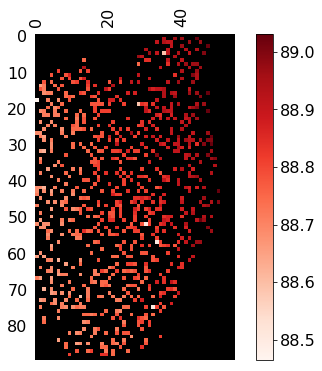

In [10]:
heatmap = np.reshape(peaks, (90,55)) #63,55 90,55

# Plot it out
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.get_cmap()
cmap=plt.cm.Reds
cmap.set_bad(color='black')
#heatmap = ax.pcolor(heatmap, cmap=plt.cm.Reds, alpha=0.8)
im = plt.imshow(heatmap, cmap=cmap)
fig.colorbar(im)

# Format
fig = plt.gcf()
fig.set_size_inches(8, 6)

# turn off the frame
ax.set_frame_on(False)

# want a more natural, table-like display
#ax.invert_yaxis()
ax.xaxis.tick_top()

# rotate the
plt.xticks(rotation=90)

ax.grid(False)

# Turn off all the ticks
ax = plt.gca()

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

fig.savefig(path.join(outpath,"heatmap.jpg"))



## Output some interesting stats to txt file 

In [11]:
#Stats

#average value of peaks
peak_average = round(np.average(peaks[np.logical_not(np.isnan(peaks))]),2)
#STD value of peaks
peak_STD = round(np.std(peaks[np.logical_not(np.isnan(peaks))]),2)
#number of positive wells
percent_positive = round(len(peaks[np.logical_not(np.isnan(peaks))])/len(peaks),3)

[peak_average, peak_STD, percent_positive]

text_file = open("Stats.txt", "w")
text_file.write("The Average Peak occurs at %f" % peak_average)
text_file.write("\n The Standard deviation of the peaks is %f" % peak_STD)
text_file.write("\n The pecentage of wells determined to be positive is %f" % percent_positive)
text_file.close()

## Output your favorite Derivative Curve 

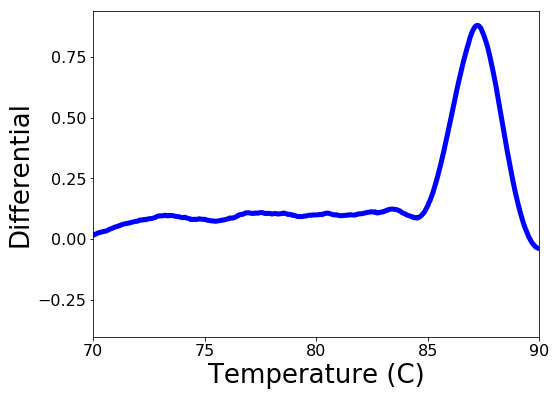

In [12]:
#columns = np.linspace(1, X-1, X-1, dtype = int)
diff_frame = pd.DataFrame(diff_data)
diff_frame_trans = diff_frame.T
# Create a new subplot from a grid of 1x1
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim([70,90])
plt.xlabel('Temperature (C)', fontsize=26)
plt.ylabel('Differential', fontsize=26)
plt.rcParams.update({'font.size': 26})

plt.plot(np.linspace(68.0, 92.9, X), diff_frame_trans[2106], color="blue", linewidth=5.0, linestyle="-")

plt.show()
fig.savefig(path.join(outpath,"Melt_curve.jpg"))

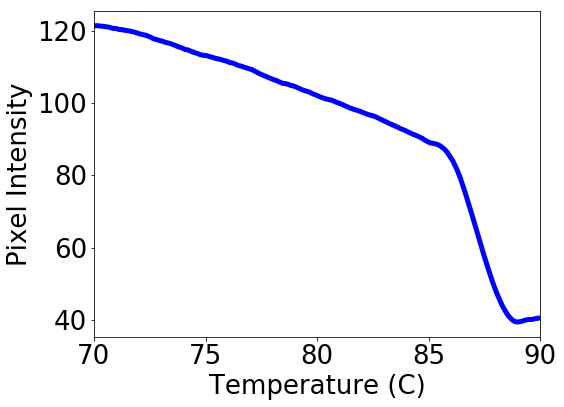

In [13]:
#columns = np.linspace(1, X-1, X-1, dtype = int)
diff_frame = pd.DataFrame(diff_data)
diff_frame_trans = diff_frame.T
# Create a new subplot from a grid of 1x1
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim([70,90])
plt.xlabel('Temperature (C)', fontsize=26)
plt.ylabel('Pixel Intensity', fontsize=26)
plt.rcParams.update({'font.size': 26})

plt.plot(np.linspace(68.0, 92.9, X+1), savgol_filter(time_series[2106+1], 95, 3), color="blue", linewidth=5.0, linestyle="-")

plt.show()
fig.savefig(path.join(outpath,"Melt_curve_raw.jpg"))

## More interesting Way to determine peaks 

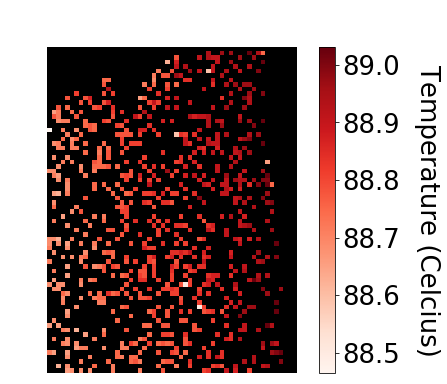

In [14]:
peaks = np.zeros((Y+1,1))
for i in range(0,Y):
    peaks[i, 0] = diff_frame_trans[i].idxmax()
peaks_median = np.median(peaks)
half_width = 10

peaks = np.zeros((Y,1))
for i in range(0,Y):
    if (diff_frame_trans[i].idxmax() > (peaks_median-half_width) and 
        diff_frame_trans[i].idxmax() < (peaks_median+half_width) and 
        diff_frame_trans[i].max() > 0.3 and 
        time_series.T[0][i]) > 0*time_series.T[0].max():
        peaks[i, 0] = diff_frame_trans[i].idxmax()*(92.9-75.0)/X+75.0
    else:
        peaks[i, 0] = float('NaN')

heatmap = np.reshape(peaks, (90,55)) #63,55 90,55

# Plot it out
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.get_cmap()
cmap=plt.cm.Reds
cmap.set_bad(color='black')

#heatmap = ax.pcolor(heatmap, cmap=plt.cm.Reds, alpha=0.8)
im = plt.imshow(heatmap[0:72,:], cmap=cmap)
#fig.colorbar(im)

# Format
fig = plt.gcf()
fig.set_size_inches(8, 6)

# turn off the frame
ax.set_frame_on(False)

# want a more natural, table-like display
#ax.invert_yaxis()
ax.xaxis.tick_top()

#Set Color Bar and Label
cbar = plt.colorbar(im)
cbar.ax.get_yaxis().labelpad = 40
cbar.set_label('Temperature (Celcius)', rotation=270)
# rotate the

plt.xticks(rotation=90)

ax.grid(False)

# Turn off all the ticks
ax = plt.gca()

#remove numeric labels
plt.axis('off')


for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False


fig.savefig(path.join(outpath,"heatmap.jpg"))

In [15]:
heatmap[0:65,:].shape

(65, 55)

In [16]:
percent_positive

0.171

In [17]:
sum(1 if i > 0.45 else 0 for i in time_series_normalized.T/np.nanmax(time_series_normalized[0]))/len(time_series_normalized[0])
#sum((i > 0.45 for i in time_series_normalized.T))

0.27151515151515154

[1.91e-01 5.34e-02 2.38e+02 7.41e-01 1.01e-01 6.83e+01] 
 [1.67e-03 1.67e-03 6.47e+00 8.05e-03 8.10e-03 4.71e+00]


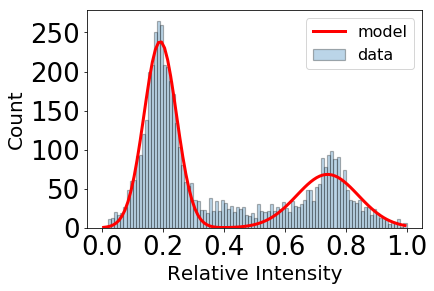

In [18]:
from pylab import *
from scipy.optimize import curve_fit

time_series_normalized = time_series_normalized[~np.isnan(time_series_normalized)]

data=concatenate((time_series_normalized/max(time_series_normalized), normal(0.75, 0.03, 500)))

y,x,_=hist(data,100,alpha=.3,label='data',
          edgecolor='black', linewidth=1.2)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(0.2, 0.2, 250, 0.8, 0.1, 125) #(mean1, b, b, mean2, b)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.xlabel('Relative Intensity', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.rcParams.update({'font.size': 16})

plot(x,bimodal(x,*params),color='red',lw=3,label='model')
legend()
print(params,'\n',sigma)